In [1019]:
import os
from time import time
import numpy as np
from numpy import pi, sin, log
from numpy.fft import rfft
from scipy.interpolate import interp1d
from scipy.special import gamma
from scipy.integrate import quad
import matplotlib.pyplot as plt

In [1020]:
mu = {
    0: { 0: 1., 2: 0., 4: 0. },
    2: { 0: 1./3., 2: 2./3., 4: 0. },
    4: { 0: 1./5., 2: 4./7., 4: 8./35. },
    6: { 0: 1./7., 2: 10./21., 4: 24./77. },
    8: { 0: 1./9., 2: 40./99., 4: 48./148. }
}

M13b = {
    0: lambda n1: 1.125,
    1: lambda n1: -(1/(1 + n1)),
    2: lambda n1: 2.25,
    3: lambda n1: (3*(-1 + 3*n1))/(4.*(1 + n1)),
    4: lambda n1: -(1/(1 + n1)),
    5: lambda n1: -9/(4 + 4*n1),
    6: lambda n1: (9 + 18*n1)/(4 + 4*n1),
    7: lambda n1: (3*(-5 + 3*n1))/(8.*(1 + n1)),
    8: lambda n1: -9/(4 + 4*n1),
    9: lambda n1: (9*n1)/(4 + 4*n1),
}

def M13a(n1):
    return np.tan(n1*np.pi)/(14.*(-3 + n1)*(-2 + n1)*(-1 + n1)*n1*np.pi)

M22b = {
    0: lambda n1, n2: (6 + n1**4*(4 - 24*n2) - 7*n2 + 8*n1**5*n2 - 13*n2**2 + 4*n2**3 + 4*n2**4 + n1**2*(-13 + 38*n2 + 12*n2**2 - 8*n2**3) + 2*n1**3*(2 - 5*n2 - 4*n2**2 + 8*n2**3) + n1*(-7 - 6*n2 + 38*n2**2 - 10*n2**3 - 24*n2**4 + 8*n2**5))/(4.*n1*(1 + n1)*(-1 + 2*n1)*n2*(1 + n2)*(-1 + 2*n2)),
    1: lambda n1, n2: (-18 + n1**2*(1 - 11*n2) - 12*n2 + n2**2 + 10*n2**3 + 2*n1**3*(5 + 7*n2) + n1*(-12 - 38*n2 - 11*n2**2 + 14*n2**3))/(7.*n1*(1 + n1)*n2*(1 + n2)),
    2: lambda n1, n2: (-3*n1 + 2*n1**2 + n2*(-3 + 2*n2))/(n1*n2),
    3: lambda n1, n2: (-4*(-24 + n2 + 10*n2**2) + 2*n1*(-2 + 51*n2 + 21*n2**2) + n1**2*(-40 + 42*n2 + 98*n2**2))/(49.*n1*(1 + n1)*n2*(1 + n2)),
    4: lambda n1, n2: (4*(3 - 2*n2 + n1*(-2 + 7*n2)))/(7.*n1*n2),
    5: lambda n1, n2: 2,
    6: lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-2 + 3*n2 + 4*n1**4*n2 + 3*n2**2 - 2*n2**3 + n1**3*(-2 - 2*n2 + 4*n2**2) + n1**2*(3 - 10*n2 - 4*n2**2 + 4*n2**3) + n1*(3 + 2*n2 - 10*n2**2 - 2*n2**3 + 4*n2**4)))/(2.*n1*(1 + n1)*(-1 + 2*n1)*n2*(1 + n2)*(-1 + 2*n2)),
    7: lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(2 + 4*n2 + 5*n2**2 + n1**2*(5 + 7*n2) + n1*(4 + 10*n2 + 7*n2**2)))/(7.*n1*(1 + n1)*n2*(1 + n2)),
    8: lambda n1, n2: ((n1 + n2)*(-3 + 2*n1 + 2*n2))/(n1*n2),
    9: lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(10 - 23*n2 + 28*n1**4*n2 + 5*n2**2 + 2*n2**3 + n1**3*(2 - 46*n2 + 28*n2**2) + n1**2*(5 - 38*n2 - 28*n2**2 + 28*n2**3) + n1*(-23 + 94*n2 - 38*n2**2 - 46*n2**3 + 28*n2**4)))/(14.*n1*(1 + n1)*(-1 + 2*n1)*n2*(1 + n2)*(-1 + 2*n2)),
    10: lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-58 + 4*n2 + 35*n2**2 + 7*n1**2*(5 + 7*n2) + n1*(4 + 14*n2 + 49*n2**2)))/(49.*n1*(1 + n1)*n2*(1 + n2)),
    11: lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-8 + 7*n1 + 7*n2))/(7.*n1*n2),
    12: lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(2 + 2*n1**3 - n2 - n2**2 + 2*n2**3 - n1**2*(1 + 2*n2) - n1*(1 + 2*n2 + 2*n2**2)))/(8.*n1*(1 + n1)*(-1 + 2*n1)*n2*(1 + n2)*(-1 + 2*n2)),
    13: lambda n1, n2: ((1 + n1 + n2)*(2 + n1 + n2)*(-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2))/(8.*n1*(1 + n1)*n2*(1 + n2)),
    14: lambda n1, n2: -((-3 + 2*n1 + 2*n2)*(-6 - n1 + 2*n1**2 - n2 + 2*n2**2))/(8.*n1*(1 + n1)*n2*(1 + n2)),
    15: lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(38 + 41*n2 + 112*n1**3*n2 - 66*n2**2 + 2*n1**2*(-33 - 18*n2 + 56*n2**2) + n1*(41 - 232*n2 - 36*n2**2 + 112*n2**3)))/(56.*n1*(1 + n1)*(-1 + 2*n1)*n2*(1 + n2)*(-1 + 2*n2)),
    16: lambda n1, n2: -((-3 + 2*n1 + 2*n2)*(9 + 3*n1 + 3*n2 + 7*n1*n2))/(14.*n1*(1 + n1)*n2*(1 + n2)),
    17: lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(5 + 5*n1 + 5*n2 + 7*n1*n2))/(14.*n1*(1 + n1)*n2*(1 + n2)),
    18: lambda n1, n2: (3 - 2*n1 - 2*n2)/(2.*n1*n2),
    19: lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2))/(2.*n1*n2),
    20: lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(50 - 9*n2 + 98*n1**3*n2 - 35*n2**2 + 7*n1**2*(-5 - 18*n2 + 28*n2**2) + n1*(-9 - 66*n2 - 126*n2**2 + 98*n2**3)))/(196.*n1*(1 + n1)*(-1 + 2*n1)*n2*(1 + n2)*(-1 + 2*n2)),
    21: lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(2 + n1 + 4*n1**3 + n2 - 8*n1*n2 - 8*n1**2*n2 - 8*n1*n2**2 + 4*n2**3))/(8.*n1*(1 + n1)*(-1 + 2*n1)*n2*(1 + n2)*(-1 + 2*n2)),
    22: lambda n1, n2: ((2 + n1 + n2)*(-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(1 + 2*n1 + 2*n2))/(8.*n1*(1 + n1)*n2*(1 + n2)),
    23: lambda n1, n2: -((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(-2 + 7*n1 + 7*n2))/(56.*n1*(1 + n1)*n2*(1 + n2)),
    24: lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(26 + 9*n2 + 56*n1**3*n2 - 38*n2**2 + 2*n1**2*(-19 - 18*n2 + 56*n2**2) + n1*(9 - 84*n2 - 36*n2**2 + 56*n2**3)))/(56.*n1*(1 + n1)*(-1 + 2*n1)*n2*(1 + n2)*(-1 + 2*n2)),
    25: lambda n1, n2: (3*(-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2))/(32.*n1*(1 + n1)*n2*(1 + n2)),
    26: lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(1 + 2*n1 + 2*n2)*(1 + 2*n1**2 - 8*n1*n2 + 2*n2**2))/(16.*n1*(1 + n1)*(-1 + 2*n1)*n2*(1 + n2)*(-1 + 2*n2)),
    27: lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(1 + 2*n1 + 2*n2)*(3 + 2*n1 + 2*n2))/(32.*n1*(1 + n1)*n2*(1 + n2)),
}

def M22a(n1, n2):
    return (gamma(1.5 - n1)*gamma(1.5 - n2)*gamma(-1.5 + n1 + n2))/(8.*np.pi**1.5*gamma(n1)*gamma(3 - n1 - n2)*gamma(n2))

### matrix for spherical bessel transform from Power spectrum to Correlation function
def MPC(l, pn):
    return np.pi**-1.5 * 2.**(-2.*pn) * gamma(1.5+l/2.-pn) / gamma(l/2.+pn)

def cH(Om,a):
    return np.sqrt(Om/a+a**2*(1-Om))
def DgN(Om,a):
    return 5./2*Om*cH(Om,a)/a*quad(lambda x:cH(Om,x)**-3,0,a)[0]
def fN(Om,z):
    a = 1./(1.+z)
    return (Om*(5*a - 3*DgN(Om,a)))/(2.*(a**3*(1 - Om) + Om)*DgN(Om,a))

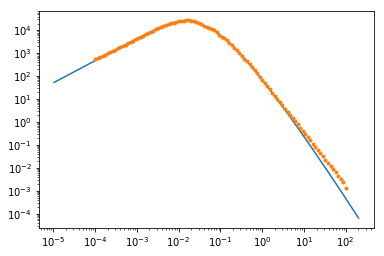

In [1192]:
def CoefWindow(N, window=1):
    n = np.arange(-N//2,N//2+1)
    if window is 1: n_cut = N//2
    else: n_cut = int(window*N//2.)
    
    n_right = n[-1] - n_cut
    n_left = n[0]+ n_cut 

    n_r=n[ n[:]  > n_right ] 
    n_l=n[ n[:]  <  n_left ] 

    theta_right=(n[-1]-n_r)/float(n[-1]-n_right-1) 
    theta_left=(n_l - n[0])/float(n_left-n[0]-1)
    
    W=np.ones(n.size)
    W[n[:] > n_right]= theta_right - 1/(2*pi)*sin(2*pi*theta_right)
    W[n[:] < n_left]= theta_left - 1/(2*pi)*sin(2*pi*theta_left)
    
    return W

class FFTLog(object):
    def __init__(self, **kwargs):
        self.Nmax = kwargs['Nmax']
        self.xmin = kwargs['xmin']
        self.xmax = kwargs['xmax']
        self.bias = kwargs['bias']
        self.dx = np.log(self.xmax/self.xmin) / (self.Nmax-1.)
        self.setx()
        self.setPow()
    
    def setx(self):
        self.x = np.empty(self.Nmax)
        for i in range(self.Nmax): 
            self.x[i] = self.xmin * np.exp(i*self.dx)
    
    def setPow(self):
        self.Pow = np.empty(self.Nmax+1, dtype = complex)
        for i in range(self.Nmax+1): 
            self.Pow[i] = self.bias + 1j * 2.*np.pi / (self.Nmax*self.dx) * (i - self.Nmax/2.)
    
    def Coef(self, xin, f, window=1, co=common):
        
        interpfunc = interp1d(xin, f)
        
        if xin[0] > self.x[0]:
            #print ('low extrapolation')
            nslow = (log(f[1])-log(f[0])) / (log(xin[1])-log(xin[0]))
            Aslow = f[0] / xin[0]**nslow
        if xin[-1] < self.x[-1]:
            #print ('high extrapolation')
            nshigh = (log(f[-1])-log(f[-2])) / (log(xin[-1])-log(xin[-2]))
            Ashigh = f[-1] / xin[-1]**nshigh
        
        fx = np.empty(self.Nmax)
        tmp = np.empty(int(self.Nmax/2+1), dtype = complex)
        Coef = np.empty(self.Nmax+1, dtype = complex)
        
        for i in range(self.Nmax): 
            if xin[0] > self.x[i]: fx[i] = Aslow * self.x[i]**nslow * np.exp(-self.bias*i*self.dx)
            elif xin[-1] < self.x[i]: fx[i] = Ashigh * self.x[i]**nshigh * np.exp(-self.bias*i*self.dx)
            else: fx[i] = interpfunc(self.x[i]) * np.exp(-self.bias*i*self.dx)
                
        tmp = rfft(fx)
        
        for i in range(self.Nmax+1):
            if (i < self.Nmax/2): Coef[i] = np.conj(tmp[int(self.Nmax/2-i)]) * self.xmin**(-self.Pow[i]) / float(self.Nmax)
            else: Coef[i] = tmp[int(i-self.Nmax/2)] * self.xmin**(-self.Pow[i]) / float(self.Nmax)
                
        Coef[0] /= 2.
        Coef[self.Nmax] /= 2.
        
        if window is not None: Coef = Coef*CoefWindow(self.Nmax, window=window)

        return Coef
        #return self.x, 
    
    def sumCoefxPow(self, xin, f, x, window=1):    
        Coef = self.Coef(xin, f, window=window)
        fFFT = np.empty_like(x)
        for i, xi in enumerate(x):
            fFFT[i] = np.real( np.sum(Coef * xi**self.Pow) )
        return fFFT

kin, Plin = np.loadtxt('output/PlinearDS1_matterpower.dat', unpack = True)
idhigh = np.where(kin > 1.)[0][0]
idlow = np.where(kin < 1e-3)[0][-1]
kin2 = kin[idlow:idhigh]
Plin2 = Plin[idlow:idhigh]

#fftPlin = dict(Nmax=256, xmin=1.5e-5, xmax=10., bias=-1.6)
fftPlin = dict(Nmax=256, xmin=1.5e-5, xmax=100., bias=-1.6)
P11 = FFTLog(**fftPlin)
plt.loglog(kin, Plin)
kplot = np.geomspace(1.e-4, 1e2, 100)
plt.loglog(kplot, P11.sumCoefxPow(kin2, Plin2, kplot, window=1), '.')



In [1040]:
class Common(object):
    def __init__(self, Nl=3, kmin=0.001, kmax=0.5):
        self.Nl = Nl
        self.N11 = 3
        self.N22 = 28 # number of 22-loops
        self.N13 = 10 # number of 13-loops
        self.k = np.arange(kmin, kmax, 0.01)
        self.Nk = self.k.shape[0]
        self.s = np.geomspace(1e-2, 1e3, 200)
        self.Ns = self.s.shape[0]

common = Common()

class Bird(object):
    def __init__(self, kin, Plin, Omega_m, z, co=common):
        self.kin = kin
        self.Pin = Plin
        self.Plin = interp1d(kin, Plin)
        self.P11 = self.Plin(co.k)
        self.f = 0.#fN(Omega_m, z)
        self.P22 = np.empty(shape=(co.N22, co.Nk))
        self.P13 = np.empty(shape=(co.N13, co.Nk))
        self.C11 = np.empty(shape=(co.Nl, co.N11, co.Ns))
        self.C22 = np.empty(shape=(co.Nl, co.N22, co.Ns))
        self.C13 = np.empty(shape=(co.Nl, co.N13, co.Ns))
        self.b11 = np.empty(shape=(co.Nl, co.N11))
        self.b13 = np.empty(shape=(co.Nl, co.N13))
        self.b22 = np.empty(shape=(co.Nl, co.N22))
    
    def setBias(self, bs, co=common):
        b1, b2, b3, b4 = bs
        f = self.f
        for i in range(co.Nl):
            l = 2*i
            self.b11[i] = np.array([b1**2, 2.*b1*f*mu[2][l], f**2*mu[4][l]])
            self.b22[i] = np.array([ b1**2*mu[0][l], b1*b2*mu[0][l], b1*b4*mu[0][l], b2**2*mu[0][l], b2*b4*mu[0][l], b4**2*mu[0][l], b1**2*f*mu[2][l], b1*b2*f*mu[2][l], b1*b4*f*mu[2][l], b1*f*mu[2][l], b2*f*mu[2][l], b4*f*mu[2][l], b1**2*f**2*mu[2][l], b1**2*f**2*mu[4][l], b1*f**2*mu[2][l], b1*f**2*mu[4][l], b2*f**2*mu[2][l], b2*f**2*mu[4][l], b4*f**2*mu[2][l], b4*f**2*mu[4][l], f**2*mu[4][l], b1*f**3*mu[4][l], b1*f**3*mu[6][l], f**3*mu[4][l], f**3*mu[6][l], f**4*mu[4][l], f**4*mu[6][l], f**4*mu[8][l] ])
            self.b13[i] = np.array([ b1**2*mu[0][l], b1*b3*mu[0][l], b1**2*f*mu[2][l], b1*f*mu[2][l], b3*f*mu[2][l], b1*f**2*mu[2][l], b1*f**2*mu[4][l], f**2*mu[4][l], f**3*mu[4][l], f**3*mu[6][l] ])
    
    def powerspectrum(self, bs, co=common):
        self.setBias(bs, co=co)
        ps11 = np.einsum('l,x->lx', np.sum(self.b11, axis=1), self.P11)
        ps22 = np.einsum('lb,bx->lx', self.b22, self.P22)
        for l in range(co.Nl): ps22[l] -= ps22[l,0]
        ps13 = np.einsum('lb,bx->lx', self.b13, self.P13)
        return ps11, ps22 + ps13
    
    def correlationfunction(self, bs, co=common):
        self.setBias(bs, co=co)
        cf11 = self.C11#np.einsum('l,lx->lx', np.sum(self.b11, axis=1), self.C11)
        cf22 = np.einsum('lb,lbx->lx', self.b22, self.C22)
        #for l in range(co.Nl): ps22[l] -= ps22[l,0]
        cf13 = np.einsum('lb,lbx->lx', self.b13, self.C13)
        return cf11, cf22 + cf13

        

In [1202]:
Omega_m = 0.0
z = 0.5
t1 = time()
bird = Bird(kin2, Plin2, Omega_m, z)
t2 = time()
print (t2-t1)

0.0006601810455322266


In [1208]:
class NonLinear(object):
    def __init__(self, co=common, load=True, save=True, path='./'):
        
        self.fftsettings = dict(Nmax=256, xmin=1.5e-5, xmax=100., bias=-1.6)
        self.fft = FFTLog(**self.fftsettings)
        
        if load is True:
            try:
                L = np.load(os.path.join(path, 'pyegg.npz'))
                if (self.fft.Pow-L['Pow']).any():
                    print ('Loaded loop matrices do not correspond to asked FFTLog configuration. \n Computing new matrices.')
                    load = False
                else:
                    self.M22, self.M13, self.Mcf11, self.Mcf22, self.Mcf13 = L['M22'], L['M13'], L['Mcf11'], L['Mcf22'], L['Mcf13']
            except:
                print ('Can\'t load loop matrices at %s. \n Computing new matrices.'%path)
                load = False
        
        if load is False:
            self.setM22()
            self.setM13()
            self.setMl()
            self.setMcf11()
            self.setMcf22()
            self.setMcf13()
        
        if save is True:
            try:
                np.savez( os.path.join(path, 'pyegg.npz'), Pow=self.fft.Pow,
                     M22=self.M22, M13=self.M13, Mcf11=self.Mcf11, Mcf22=self.Mcf22, Mcf13=self.Mcf13 )
            except:
                print ('Can\'t save loop matrices at %s.'%path)
        
        self.setkPow(co=co)
        self.setsPow(co=co)
        
        # To speed-up matrix multiplication:
        self.optipathP22 = np.einsum_path('nk,mk,bnm->bk', self.kPow, self.kPow, self.M22, optimize='optimal')[0]
        self.optipathC13 = np.einsum_path('ns,ms,blnm->bls', self.sPow, self.sPow, self.Mcf22, optimize='optimal')[0]
        self.optipathC22 = np.einsum_path('ns,ms,blnm->bls', self.sPow, self.sPow, self.Mcf13, optimize='optimal')[0]
        
    def setM22(self, co=common):
        self.M22 = np.empty(shape=(co.N22, self.fft.Pow.shape[0], self.fft.Pow.shape[0]), dtype='complex')
        # common piece of M22
        Ma = np.empty(shape=(self.fft.Pow.shape[0], self.fft.Pow.shape[0]), dtype='complex')
        for u, n1 in enumerate(-0.5*self.fft.Pow):
            for v, n2 in enumerate(-0.5*self.fft.Pow):
                Ma[u,v] = M22a(n1, n2)
        for i in range(co.N22): 
            # singular piece of M22
            Mb = np.empty(shape=(self.fft.Pow.shape[0], self.fft.Pow.shape[0]), dtype='complex')
            for u, n1 in enumerate(-0.5*self.fft.Pow):
                for v, n2 in enumerate(-0.5*self.fft.Pow):
                    Mb[u,v] = M22b[i](n1, n2)
            self.M22[i] = Ma*Mb
    
    def setM13(self, co=common):
        self.M13 = np.empty(shape=(co.N13, self.fft.Pow.shape[0]), dtype='complex')
        Ma = M13a(-0.5*self.fft.Pow)
        for i in range(co.N13): self.M13[i] = Ma*M13b[i](-0.5*self.fft.Pow)
    
    def setMcf11(self, co=common):
        self.Mcf11 = np.empty(shape=(co.Nl, self.fft.Pow.shape[0]), dtype='complex')
        for l in range(co.Nl):
            for u, n1 in enumerate(-0.5*self.fft.Pow):
                self.Mcf11[l,u] = MPC(2*l, n1)
        
    def setMl(self, co=common):
        self.Ml = np.empty(shape=(co.Nl, self.fft.Pow.shape[0], self.fft.Pow.shape[0]), dtype='complex')
        for l in range(co.Nl):
            for u, n1 in enumerate(-0.5*self.fft.Pow):
                for v, n2 in enumerate(-0.5*self.fft.Pow):
                    self.Ml[l,u,v] = MPC(2*l, n1+n2-1.5)
    
    def setMcf22(self):
        self.Mcf22 = np.einsum('lnm,bnm->blnm', self.Ml, self.M22)
    
    def setMcf13(self):
        self.Mcf13 = np.einsum('lnm,bn,bm->blnm', self.Ml, self.M13, self.M13)
    
    def setkPow(self, co=common):
        self.kPow = np.exp(np.einsum('n,k->nk', self.fft.Pow, np.log(co.k)))
    
    def setsPow(self, co=common):
        self.sPow = np.exp(np.einsum('n,s->ns', -self.fft.Pow-3., np.log(co.s)))
    
    def CoefkPow(self, Coef):
        return np.einsum('n,nk->nk', Coef, self.kPow )
    
    def CoefsPow(self, Coef):
        return np.einsum('n,ns->ns', Coef, self.sPow )
    
    def makeP22(self, CoefkPow, bird, co=common):
        bird.P22 = co.k**3 * np.real( np.einsum('nk,mk,bnm->bk', CoefkPow, CoefkPow, self.M22, optimize=self.optipathP22 ) )
    
    def makeP13(self, CoefkPow, bird, co=common):
        bird.P13 = co.k**3 * bird.P11 * np.real( np.einsum('nk,bn->bk', CoefkPow, self.M13) )
        
    def makeC11(self, CoefsPow, bird):
        bird.C11 = np.real( np.einsum('ns,ln->ls', CoefsPow, self.Mcf11) )
        
    def makeC22(self, CoefsPow, bird):
        bird.C22 = np.real( np.einsum('ns,ms,blnm->lbs', CoefsPow, CoefsPow, self.Mcf22, optimize=self.optipathC22 ) )
    
    def makeC13(self, CoefsPow, bird):
        bird.C13 = np.real( np.einsum('ns,ms,blnm->lbs', CoefsPow, CoefsPow, self.Mcf13, optimize=self.optipathC13 ) )
        
    def Coef(self, bird, window=None, co=common):
#         if bird.kin[0] > self.fftsettings['xmin']: print ('Please provide a linear power spectrum with kmin < %s'%self.fftsettings['xmin'])
#         if bird.kin[-1] < self.fftsettings['xmax']: print ('Please provide a linear power spectrum with kmax > %s'%self.fftsettings['xmax'])
        return self.fft.Coef(bird.kin, bird.Pin, window=window)
    
    def Ps(self, bird, co=common):
        coef = self.Coef(bird, co=co)
        coefkPow = self.CoefkPow(coef)
        self.makeP22(coefkPow, bird, co=co)
        self.makeP13(coefkPow, bird, co=co)
        
    def Cf(self, bird, co=common):
        coef = self.Coef(bird, co=co)
        coefsPow = self.CoefsPow(coef)
        self.makeC11(coefsPow, bird)
        self.makeC22(coefsPow, bird)
        self.makeC13(coefsPow, bird)
    
    def PsCf(self, bird, co=common):
        coef = self.Coef(bird, co=co)
        coefkPow = self.CoefkPow(coef)
        coefsPow = self.CoefsPow(coef)
        self.makeP22(coefkPow, bird, co=co)
        self.makeP13(coefkPow, bird, co=co)
        self.makeC11(coefsPow, bird)
        self.makeC22(coefsPow, bird)
        self.makeC13(coefsPow, bird)

In [1209]:
nonlinear = NonLinear(load=True,save=True)

In [1205]:
t1 = time()
for i in range(1):
    #nonlinear.Ps(bird)
    #nonlinear.Cf(bird)
    nonlinear.PsCf(bird)
t2 = time()
print (t2-t1)

0.38548803329467773


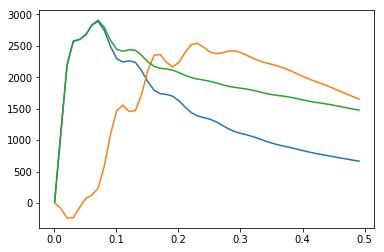

In [1206]:
bs = np.array([2., 0.8, 0.5, 0.8])
pslin, psloop = bird.powerspectrum(bs)
plt.plot(common.k, common.k * pslin[0])
plt.plot(common.k, psloop[0])
plt.plot(common.k, common.k * (pslin[0]+psloop[0]))

(-11, 42)

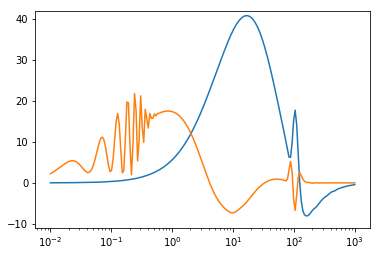

In [1207]:
bs = np.array([1., 1., 1., 0.])
cflin, cfloop = bird.correlationfunction(bs)
plt.semilogx(common.s, common.s**2 * cflin[0])
plt.semilogx(common.s, common.s**2 * cfloop[0])
plt.ylim(-11,42)

In [924]:
t1 = time()
for i in range(100):
    nonlinear.Coef(bird)
t2 = time()
print (t2-t1)

0.8017332553863525
